# Realizable PID Control

The next part that needs attention is the derivative control term which is currently implemented as

\begin{align}
D & = K_D\frac{de^D}{dt} \approx K_D\frac{e^D_k - e^D_{k-1}}{t_k - t_{k-1}}
\end{align}

where is a weighted difference between the setpoing and process variable $e^D = \gamma SP - PV$.

This term clearly presents problems as the control sampling period gets small. Any difference between $e^D_k$ and $e^D_{k-1}$ due to measurement noise, for example, will be magnified when divided by the small difference between $t_k$ and $t_{k-1}$.

## Example: PID Control with Significant Measurement Noise

Here we start with the PID control algorithm that implements setpoint weighting and anti-reset windup. 

In [3]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        I = I + Ki*(SP - PV)*(t - t_prev)
        eD = gamma*SP - PV
        D = Kd*(eD - eD_prev)/(t - t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV
        I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

We modify the control problem by introducing a signficant degree of measurement noise.

\begin{align}
T^{meas}_{1,k} & = T_{1,k} + e_k
\end{align}

where the measurement error is a normal random variable with zero mean and a standard deviation of 2°C. For this example we've deliberately chosen a large value of $K_D = 10$ to illustrate the issue of using significant amounts of derivative control in presence of measurement noise.

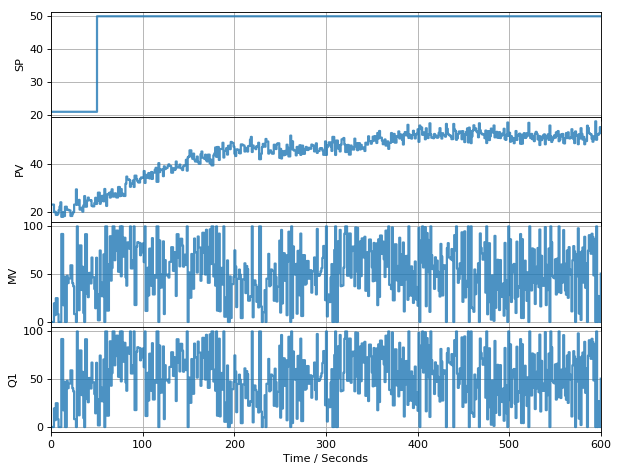

TCLab Model disconnected successfully.


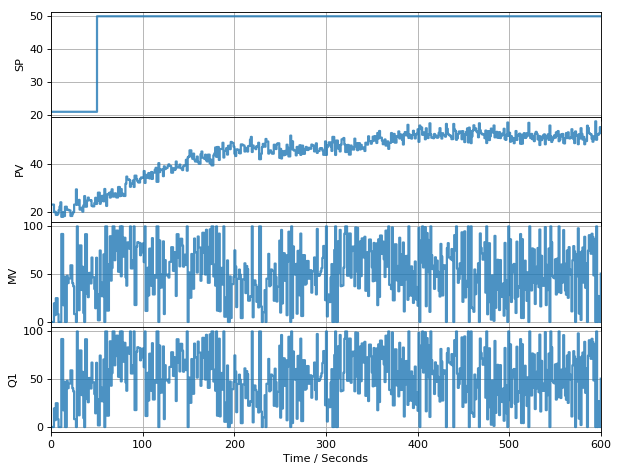

In [4]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
import numpy as np

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 10, beta=0)   # create pid control
controller.send(None)                  # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('PV', lambda: PV), ('MV', lambda: MV), ('Q1', lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        SP = T1 if t < 50 else 50                     # get setpoint
        PV = lab.T1 + 2*np.random.normal()            # get measurement
        MV = controller.send([t, PV, SP, lab.Q1()])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display

## Modifying the Derivative Term

To avoid problems with high frequency measurement noise and disturbances, consider an implementation of the derivative term of PID control using a first-order model

\begin{align}
\tau_f \frac{dD}{dt} + D & = K_D \frac{de^D}{dt}
\end{align}

where $e^D = \gamma SP - PV$ is the setpoint weighted error. The idea behind this model is that, for slowly varying changes, $D \sim K_d \frac{de_D}{dt}$ which provides the desired derivative control function, and for more rapidly varying changes $\tau_f \frac{dD}{dt} + D \sim K_d \frac{de_D}{dt}$ which dissipates the influence of more rapidly varying changes attributable to measurement noise.

The characteristic time constant $\tau_f$ is chosen as a fraction of the derivative time constant $\tau_D$

\begin{align}
\tau_f & = \frac{\tau_D}{N} = \frac{K_D}{NK_P}
\end{align}

Rearraging for $D$ and integrating this model gives

\begin{align}
D & =  \frac{K_D}{\tau_f} e^D - \frac{1}{\tau_f} \int_0^t D\ dt 
\end{align}

In discrete time we define and use a backwards difference approximation to obtain

\begin{align}
S_k & = \int_0^{t_k} D\ dt \\
& \approx \sum_{k'=1 }^{k} D_{k'} (t_{k'} - t_{k'-1}) = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

The backwards difference approximation provides a recursion relationship that is stable for all $t_k \geq t_{k-1}$. We are thereby tracking a pair of implicit recursion relations

\begin{align}
D_k & = \frac{K_D}{\tau_f} e^D_k - \frac{1}{\tau_f} \left[ D_k(t_k - t_{k-1}) + S_{k-1} \right] \\
\\
S_k & = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

Making these explicit

\begin{align}
D_k & = \frac{K_D e^D_k - S_{k-1}}{\tau_f + (t_k - t_{k-1})}  \\
\\
S_k & = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

Finally, using parameters for the non-interacting model of PID control

\begin{align}
D_k & = \frac{NK_P(K_De^D_k - S_{k-1})}{K_D + NK_P(t_k - t_{k-1})}  \\
\\
S_k & = D_k (t_k - t_{k-1}) + S_{k-1}
\end{align}

This recursive calculation can be initialized with $S_0 = K_De^D_0$.

## Example Revisited

To show the impact of this change in the implementation of the derivative term, we repeat the experiment above with the revised algorithm and $N = 1$.  (A more typical value of $N$ is 5 or 10, but we've chosen a somewhat more conservative value because of the magnitude of the measurement noise present in this example, and the large value of $K_D$ chosen to demonstrate the issues.

In [1]:
def PID(Kp, Ki, Kd, MV_bar=0, MV_min=0, MV_max=100, beta=1, gamma=0, N=10):

    # initial yield and return
    data = yield MV_bar
    t,  = data[0:3]
    
    P = Kp*(beta*SP - PV)
    MV = MV_bar + P
    MV = 0 if MV < 0 else 100 if MV > 100 else MV
    I = 0
    D = 0
    dI = 0
    
    S = Kd*(gamma*SP - PV)
    t_prev = t
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV, P, I, D, dI
        
        # see if a tracking data is being supplied
        if len(data) < 4:
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            d = MV - TR
            #I = TR - MV_bar - P - D
        
        # PID calculations
        P = Kp*(beta*SP - PV)
        eD = gamma*SP - PV
        D = N*Kp*(Kd*eD - S)/(Kd + N*Kp*(t - t_prev))
        
        # conditional integration
        dI = Ki*(SP - PV)*(t - t_prev)
        if (MV_bar + P + I + D + dI) > MV_max:
            dI = max(0, min(dI, MV_max - MV_bar - P - I - D))
        if (MV_bar + P + I + D + dI) < MV_min:
            dI += min(0, max(dI, MV_min - MV_bar - P - I - D))
        I += dI
        MV = MV_bar + P + I + D 
        
        # Clamp MV to range 0 to 100 for anti-reset windup
        MV = max(MV_min, min(MV_max, MV))
        
        # update stored data for next iteration
        S = D*(t - t_prev) + S
        t_prev = t

The desired setpoint is 50°C which is acheived with a power setting of approximately 50%.  We'll start out at the power setting for a period of 400 seconds, then turn on the controller.

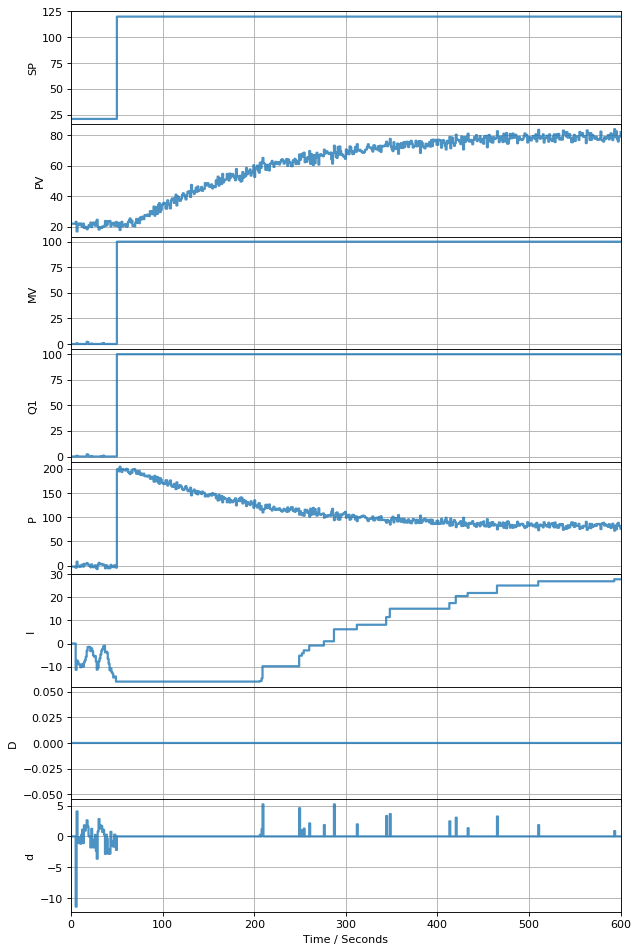

TCLab Model disconnected successfully.


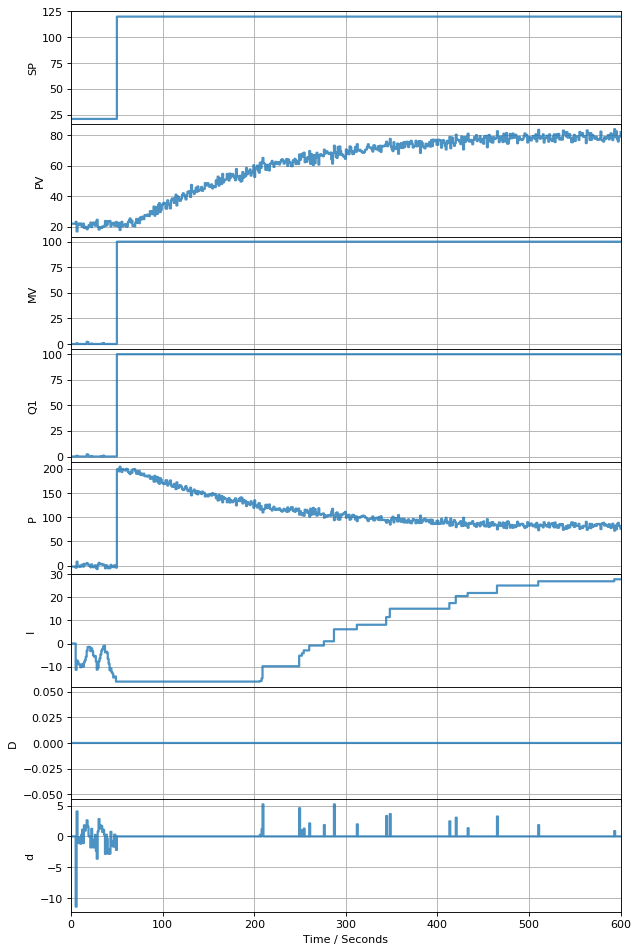

In [2]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter
import numpy as np

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 1, 0, beta=1, N=1)   # create pid control
controller.send(None)                  # initialize

tfinal = 600

with TCLab() as lab:
    h = Historian([('SP', lambda: SP), ('PV', lambda: PV), ('MV', lambda: MV), ('Q1', lab.Q1),
                   ('P', lambda: P), ('I', lambda: I), ('D', lambda: D), ('d', lambda: d)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 1):
        SP = T1 if t < 50 else 120                     # get setpoint
        PV = lab.T1 + 2*np.random.normal()            # get measurement
        MV, P, I, D, d = controller.send([t, PV, SP, lab.Q1()])   # compute manipulated variable
        lab.Q1(MV)                                    # apply 
        p.update(t)                                   # update information display